<h1>
<center>
    <b>
    📉 U.S. Stock Market Sentiment Analysis Tool 📈
    </b>
</center>
</h1>

<center>
The main purpose of this script will be to scrape through popular financial news sites using <b>BeautifulSoup4</b> and the <b>Finnhub API</b> (built on REST API) to make calls to multiple news sites efficiently, and parse through important information that will be stored and used for data processing at the end. We will be using the pre-trained NLP model, <b>BERT</b> to "score" news headlines based on language sentiment, <b>Pandas</b> and <b>Numpy</b> to organize data, and <b>Matplotlib</b>t to help visualize results.
</center>

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import datetime
import requests
import torch
import pandas as pd
import numpy as np
import re
import sys

<center>

I'll be using the the pre-trained <b>BERT model</b> for this script. It'll make the "scoring system" efficient and easy to implement:
</center>

In [4]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [34]:
ticker_input = input("What US ticker would you like to analyze? ")  
ticker_cap = str(ticker_input.upper())


# using the datetime library to fetch today's date and last month's day to plug it into the finnhub API url
today = datetime.date.today()
past_date = today - datetime.timedelta(days=30)
from_date = past_date.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')


finviz_url = f"https://finviz.com/quote.ashx?t={ticker_cap}&p=d"

API_KEY = 'crmusn9r01qmi0u6b5agcrmusn9r01qmi0u6b5b0'
finnhub_news_url = f'https://finnhub.io/api/v1/company-news?symbol={ticker_cap}&from={from_date}&to={to_date}&token={API_KEY}'
finnhub_ticker_url = finnhub_url = f'https://finnhub.io/api/v1/stock/symbol?exchange=US&token={API_KEY}'


What US ticker would you like to analyze?  amd


Calling the <b>Finnhub API</b> where most of the data will be extracted from:

In [36]:
ticker_response = requests.get(finnhub_ticker_url)
ticker_items = ticker_response.json()
ticker_list = [item['symbol'] for item in ticker_items]

if ticker_cap not in ticker_list:
    raise Exception(f"Error: '{ticker_input}' is not a valid U.S. ticker symbol.")


Using <b>Requests</b> to GET the HTML file of an additional news source (Finviz), and parse through it using <b>BeautifulSoup4</b>:

In [38]:
request = requests.get(url = finviz_url, headers = {'user-agent': 'my-app'})
soup = BeautifulSoup(request.text, 'html.parser')
regex = re.compile('.*tab-link-news.*')
results = soup.find_all('a', {'class':regex})
finviz_parsed_data = [result.text for result in results]


news_response = requests.get(finnhub_news_url)
news_items = news_response.json()

headlines_with_date = [ 
    {
        'headline' : item['headline'],
    }
    for item in news_items
]

Using <b>Pandas</b> and <b>Numpy</b> to store and process data efficiently using the pre-trained model:

In [40]:
finnhub_news_data = []
for news in headlines_with_date:
    finnhub_news_data.append(news['headline'])


dataframe_list = finviz_parsed_data + finnhub_news_data
df = pd.DataFrame(np.array(dataframe_list), columns = ['Headlines'])

Initially preprocessing the news headlines to make it easier for the model to interpret sentiment of <b>key words</b> (increases accuracy) by making all characters lowercase, tokenizing words individually, removing stopwords (except negation words/phrases), and lemmatizing:

In [45]:
# this function will preprocess the headline to increase accuracy on the model
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# makes sure negation words are not considered stop words (important for bias)
negation_words = {"not", "no", "never", "neither", "none", "no one"}
def preprocessed_headline(headline):
    headline = headline.lower() # all lowercase characters
    headline = re.sub(r'[^a-zA-Z0-9\s]', '', headline) # removes special characters
    words = headline.split() # 'tokenizing' the words
    words = [word for word in words 
            if word not in stop_words or word in negation_words]
    
    words = [lemmatizer.lemmatize(word) for word in words]
    clean_headline = ' '.join(words)

    return clean_headline


Running the <b>BERT</b> model on a headline. Implemented <b>split_text</b> to separate text into chunks for efficient processing and <b>mean_sentiment</b> to take an average of the sentiment of all text chunks combined:

In [48]:
# runs the sentiment_score on a single headline
def sentiment_score(headline):
    token = tokenizer.encode(headline, return_tensors='pt', truncation = True, padding = True, max_length = 512)

    with torch.no_grad():
        result = model(token)

    probabilities = torch.nn.functional.softmax(result.logits, dim =-1)
    probabilities_np = probabilities.numpy()[0]
    sentiment_score = sum((i+1) * probabilities_np[i] for i in range(5))  # i+1 because scores are 1 to 5
    # weight = abs(sentiment_score)

    return sentiment_score

# splits the input text into 512-token chunks
def split_text(text, max_tokens = 512): 
    if len(text) == 0:
        return []
    return [text[i:i + max_tokens] for i in range(0, len(text), max_tokens)]

# takes the mean of all chunks that had a sentiment score ran on them
def mean_sentiment(text):
    chunks = split_text(text)

    if not chunks:
        return None
    
    scores = [sentiment_score(chunk) for chunk in chunks]

    return np.mean(scores)

Applying <b>preprocessed_headline</b> to each headline in the Pandas dataframe, then <b>sentiment_score</b> to each headline. To finally get the general sentiment of the specific ticker, the mean of all rows in 'Sentiment' is taken:

In [51]:
df['Processed_Headlines'] = df['Headlines'].apply(preprocessed_headline)
df['Sentiment'] = df['Processed_Headlines'].apply(lambda x: mean_sentiment(x))
mean_of_scores = round(df['Sentiment'].mean(), 2)

All headlines with their individual sentiment score is printed. Below the dataframe is the general mean of the ticker's sentiment:

In [53]:
print(df.loc[0:10, ['Headlines', 'Sentiment']])

print()

if mean_of_scores >= 1 and mean_of_scores < 1.8 :
    print("Extremely Bearish: " + str(mean_of_scores))
elif mean_of_scores >= 1.8 and mean_of_scores < 2.6:
    print("Moderatly Bearish: " + str(mean_of_scores))
elif mean_of_scores >= 2.6 and mean_of_scores < 3.4:
    print("Neutral: " + str(mean_of_scores))
elif mean_of_scores >= 3.4 and mean_of_scores < 4.2:
    print("Moderatly Bullish: " + str(mean_of_scores))
elif mean_of_scores >= 4.2 and mean_of_scores <= 5:
    print("Extremely Bullish: " + str(mean_of_scores))

                                            Headlines  Sentiment
0   Is There Still Time to Buy These 2 Artificial ...   3.666788
1   Nvidia Stock (NVDA) Is Still a Long-Term Winne...   4.517733
2   Harbor Capital Appreciation Fund's Strategic M...   4.039115
3   If You Bought 1 Share of Intel Stock at Its IP...   2.346793
4   Wedbush Reaffirms Outperform Rating On Advance...   3.931691
5   Best ETF to Buy: VanEck Semiconductor ETF vs. ...   4.848207
6   How To Sell Stocks: Use This Signal To Lock In...   2.980181
7   Intel Just Caught Up to AMD in This Critical M...   2.329619
8   Better Artificial Intelligence (AI) Stock: Nvi...   3.252408
9   1 Unstoppable Semiconductor ETF That Could Tur...   1.471399
10  Is Advanced Micro Devices, Inc. (AMD) the Best...   4.834434

Moderatly Bullish: 3.48


Plotting the sentiment distribution on a Histogram using <b>Matplotlib</b>:

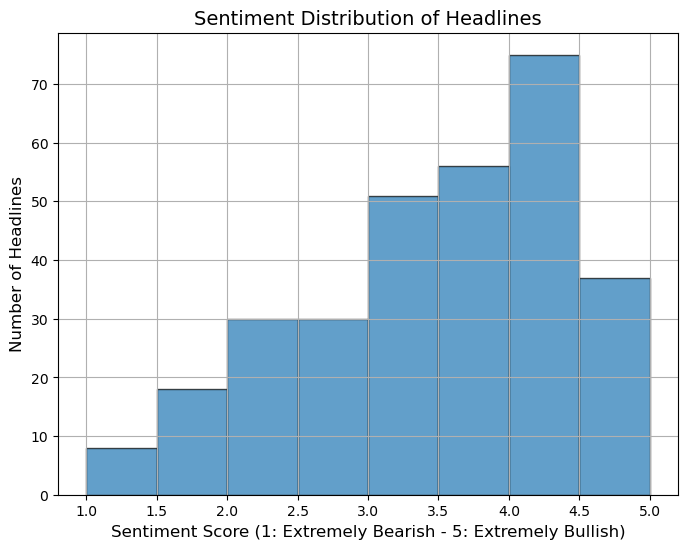

In [55]:
# Plotting sentiment distribution
bins = np.arange(1, 5.5, 0.5)

plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment'], bins=bins, edgecolor='black', alpha=0.7)
plt.title('Sentiment Distribution of Headlines', fontsize=14)
plt.xlabel('Sentiment Score (1: Extremely Bearish - 5: Extremely Bullish)', fontsize=12)
plt.ylabel('Number of Headlines', fontsize=12)
plt.grid(True)
plt.show()
